In [96]:
import numpy as np
import matplotlib.pyplot as plt
from backend import TwoDimNav, PC_AC_agent, plot_maps

In [97]:
episodes = 1000
tmax = 100
maxspeed = 0.25
goalsize = 0.25
startcoord = [0.0,0.0]
goalcoord = [0.7, 0.7]

env = TwoDimNav(startcoord=startcoord, goalcoord=goalcoord, goalsize=goalsize, tmax=tmax, maxspeed=maxspeed)

[0.0, 0.0]


In [98]:
# initialize agent
alr = 0.00  # 0.0075
clr = 0.00  # 0.025
nact = 4
gamma = 0.95

npc = 21
pcr = 0.25
seed = 2023

def get_placefield_weights(npc,pcr, nact):
    pcspacing = np.linspace(-1,1,npc) # uniformly space place cells
    pcr =  pcr # define radius of place cells
    xx, yy = np.meshgrid(pcspacing, pcspacing)
    pcs = np.concatenate([xx.reshape(-1,1), yy.reshape(-1,1)],axis=1)
    theta = np.random.normal(size=(npc**2, nact))*1e-3
    return pcs, theta


def get_pc_activity(pcs, pcr, x):
    # convert x,y coordinate to place cell activity
    norm = np.sum((x - pcs)**2,axis=1)
    pcact = np.exp(-norm / (2 * pcr **2))
    return pcact

def softmax(prob):
    return np.exp(prob) / np.sum(np.exp(prob))

def get_action_prob(theta, pcact, beta=2):
    return softmax(beta * np.matmul(theta.T, pcact))

def get_onehot_g(prob, nact=4):
    A = np.random.choice(a=np.arange(nact), p=np.array(prob))
    onehotg = np.zeros(nact)
    onehotg[A] = 1
    return onehotg

def get_discounted_rewards(rewards, gamma=0.95, norm=False):
    discounted_rewards = []
    cumulative = 0
    for reward in rewards[::-1]:
        cumulative = reward + gamma * cumulative  # discounted reward with gamma
        discounted_rewards.append(cumulative)
    discounted_rewards.reverse()
    return discounted_rewards

pcs, theta = get_placefield_weights(npc, pcr, nact)
inittheta = theta.copy()

In [99]:
def get_coord_reward():
    eps_info = []

    for e in range(episodes):
        state, goal, eucdist, done = env.reset()

        rewards = []
        activities = []

        for t in range(tmax):

            pcact = get_pc_activity(pcs, pcr, state)

            aprob = get_action_prob(theta, pcact)
            
            onehotg = get_onehot_g(aprob)

            # eucdist is euclediean distance to goal, done is a sparse scalar reward signal 
            newstate, eucdist, done = env.step(onehotg) 

            rewards.append(int(done))

            # use scalar sparse reward signal to update TD error
            #agent.learn(newstate=newstate, reward=done)

            # get derivatives
            activities.append(np.matmul(pcact[:,None],(onehotg - aprob)[:,None].T))

            #trial_info.append([pcact, aprob, onehotg, int(done)])

            state = newstate.copy()

            if done:
                break
        
        disc_rewards = np.array(get_discounted_rewards(rewards))[:,None,None]
        grad = np.sum(np.array(activities) * np.array(disc_rewards),axis=0)

        eps_info.append(grad)

        #print(f'E {e+1}/{train_episodes} in {t} steps')
    return eps_info

In [100]:
# get dataset with 1000 random trajectories, not all are rewarded
episode_info = get_coord_reward()


In [101]:
# Update theta using expectation of random trajectory and rewards

theta += np.mean(episode_info,axis=0)


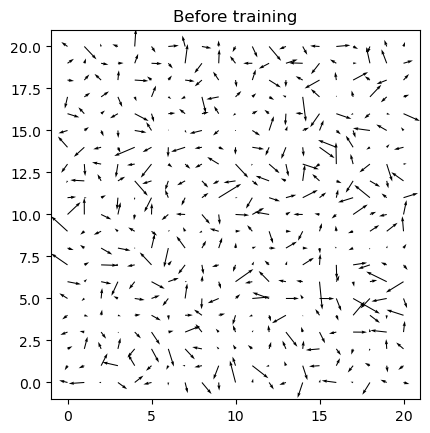

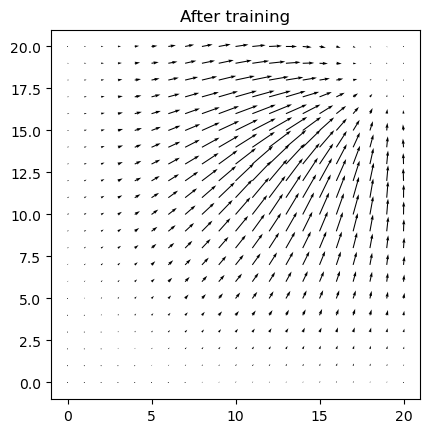

In [102]:
plot_maps(env, npc, inittheta, title='Before training')
plot_maps(env, npc, theta, title='After training')